To Try:
* Use Frasa Segmentation
* Use Qarib
* Fine Tuning ?
* Hyper parameter
* Confusion Matrix
* See distribution of cases
* try other vectorizers (TF-IDF)
* 

To Answer:
* Numbber of training examples vs Accuracy of the model?
* 



In [19]:
!pip install transformers
!pip install farasapy
!pip install pyarabic
!pip install python-bidi
!pip install arabic_reshaper
!pip install lime
!git clone https://github.com/aub-mind/arabert 
!pip install ktrain

fatal: destination path 'arabert' already exists and is not an empty directory.


In [20]:
#Checking for GPU
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [21]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [22]:
dataset_directory = 'gdrive/MyDrive/HBKU/Research/datasets/tutorial/'
!ls '$dataset_directory'

'data - data.csv'     rawi_bio_category.csv    spidyquotes-viewstate.py
 narrators.csv	      rawi_bio.csv	       takhreeg.csv
 narrators-utf8.csv   rawi_bio_grade.csv       takhreeg.numbers
 quotes-1.html	      rawi_bio_grade_old.csv   tutorial
 quotes-2.html	      README.md
 quotes.json	      scrapy.cfg


In [23]:
import pandas as pd
import numpy as np

from farasa.segmenter import FarasaSegmenter
from arabert.preprocess_arabert import preprocess, never_split_tokens

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score
import sklearn.feature_extraction

from transformers import AutoConfig, AutoTokenizer
from transformers.data.processors import SingleSentenceClassificationProcessor
from transformers import Trainer , TrainingArguments

#viz
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
import arabic_reshaper

import matplotlib.gridspec as gridspec 
import seaborn as sns

import ktrain
from ktrain import text

import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

farasa_segmenter = FarasaSegmenter(interactive=True)

[2020-12-15 15:35:04,363 - farasapy_logger - ERROR]: an error occured
[2020-12-15 15:35:04,364 - farasapy_logger - ERROR]: HTTPSConnectionPool(host='farasa-api.qcri.org', port=443): Max retries exceeded with url: /farasapy/releases/download/toolkit-bins-released/farasa_bin.zip (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)'),))
[2020-12-15 15:35:04,368 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [24]:
path_narrators = dataset_directory + '/narrators.csv'
df_narrators = pd.read_csv(path_narrators, header=0)

df_narrators.head()

,rawi_index,name,grade
0,3,آدم بن أبي إياس : عبد الرحمن بن محمد ، وقيل : ...,ثقة عابد
1,4,آدم بن سليمان,صدوق
2,5,آدم بن علي,صدوق
3,6,أم قيس بنت محصن بن حرثان بن قيس بن مرة بن كبير...,صحابية مشهورة
4,7,أم حرام ، يقال اسمها : آمنة,NaN


In [25]:
path_bio_category = dataset_directory + '/rawi_bio_category.csv'
df_bio_category = pd.read_csv(path_bio_category, header=0)

df_bio_category.head()

,rawi_index,faeeda_id,faeeda_source,faeeda_category,faeeda_text
0,3,48003065,441140,إثبات سماع الراوي,<span>قال محمد بن سعد : كان من أبناء أهل خراسا...
1,3,49003698,464601,إثبات سماع الراوي,<span>وقال ابن سعد : سمع من شعبة سماعا كثيرا</...
2,3,520035218,531969,إثبات سماع الراوي,<span>وقال ابن سعد في « الطبقات الكبير » : سمع...
3,4,490037010,464603,الإرسال,<span>ولم يدركه ابنه</span>
4,4,50002602,490291,إثبات سماع الراوي,<span>سمع سعيد بن جبير</span>


In [26]:
path_bio = dataset_directory + '/rawi_bio.csv'
df_bio = pd.read_csv(path_bio, header=0)

df_bio.head()

,rawi_index,targama_id,page_source,targama_text
0,3,685187,"<div class=""Header""> جزء: 2 صفحة: 268</div>",<span>\r\n <span>\r\n </span>970...
1,3,608014,"<div class=""Header""> جزء: 8 صفحة: 134</div>",<span>\r\n <span>\r\n </span>\r\...
2,3,823579,"<div class=""Header""> جزء: 7 صفحة: 486</div>",<span>\r\n <span>\r\n </span>344...
3,3,441140,"<div class=""Header""> جزء: 2 صفحة: 301</div>",<span>\r\n <span>\r\n </span>294...
4,3,490289,"<div class=""Header""> جزء: 2 صفحة: 86</div>",<span>\r\n <span>\r\n </span>\r\...


In [27]:
path_bio_grade = dataset_directory + '/rawi_bio_grade.csv'
df_bio_grade = pd.read_csv(path_bio_grade, header=0)

df_bio_grade.head()

,rawi_index,faeeda_id,faeeda_source,scholar_name,faeeda_text
0,3,490036912,464601,أبو حاتم الرازي,<span>وقال أبو حاتم : ثقة مأمون متعبد من خيار ...
1,3,61012906,685187,أبو حاتم الرازي,<span>روى عن : شعبة ، وإسرائيل ، والمسعودي ، و...
2,3,48003069,441140,أبو حاتم الرازي,<span>وقال أبو حاتم : ثقة مأمون . متعبد من خيا...
3,3,50002592,490289,أبو حاتم الرازي,<span>قال أبو حاتم : ثقة مأمون متعبد من خيار ع...
4,3,61012904,685187,أبو حاتم الرازي,<span>سئل أبي عن آدم بن أبي إياس فقال : ثقة مأ...


In [28]:
#Cleaning the data
#remove duplicates
#fill empty cells
#same text, multi label
print("Check for missing values in Train dataset")
null_check=df_bio_category.isnull().sum()
print(null_check)
#print("filling NA with \"unknown\"")
#df_bio_category["faeeda_category"].fillna("unknown", inplace=True)

from bs4 import BeautifulSoup

cleantext = BeautifulSoup(df_bio["targama_text"][50], "lxml").text
cleantext

Check for missing values in Train dataset
rawi_index          0
faeeda_id          21
faeeda_source       8
faeeda_category     0
faeeda_text         0
dtype: int64


'\n\n\nأبان بن إسحاق الأسدي النحوي . من أهل الكوفة ، يروي عن الصباح بن محمد ، روى عنه ابن نمير ويعلى بن عبيد . '

In [29]:
#split to test and train
#split train to k folds fro validation
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'

df_bio_category = df_bio_category[['faeeda_text', 'faeeda_category']]
df_bio_category.columns = [DATA_COLUMN, LABEL_COLUMN]

df_bio_category[DATA_COLUMN] = df_bio_category[DATA_COLUMN].apply(lambda x: preprocess(x, do_farasa_tokenization=False , farasa=farasa_segmenter, use_farasapy = True))
X_train, X_test = train_test_split(df_bio_category, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(12770, 2)
(3193, 2)


Max of train len:  938
Max of test len:  384


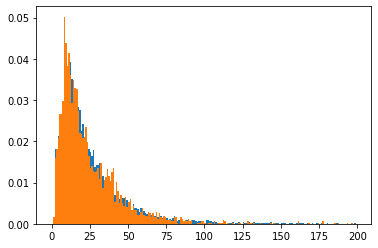

In [30]:
train_sentence_length = [ len(text.split()) for text in X_train['text'] ]
test_sentence_length = [ len(text.split()) for text in X_test['text'] ]

print("Max of train len: ",np.max(train_sentence_length))
print("Max of test len: ",np.max(test_sentence_length))

plt.hist(train_sentence_length,bins= range(200),density=True)
plt.hist(test_sentence_length,bins= range(200),density=True)
plt.show()

In [31]:
cats = df_bio_category.groupby("label").nunique()
class_names = list(cats.index)

In [32]:
print(',\n'.join(class_names))

faeeda_category,
إثبات سماع الراوي,
الإدراك,
الإرسال,
الاختلاط,
الاختلاف في سماع الراوي,
التدليس,
التضعيف الاستثنائي,
التضعيف الضمني,
التوثيق الاستثنائي,
التوثيق الضمني,
المفاضلة بين الرواة,
المفاضلة بين الرواة في بلد,
المفاضلة بين الرواة في راو


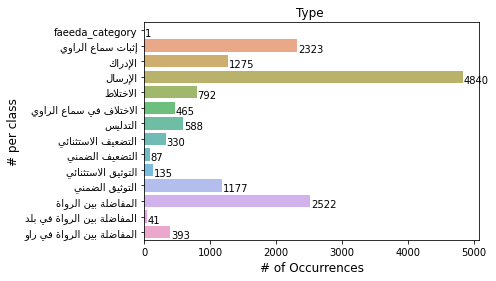

In [33]:
plt.figure()

reshaped_categories = [get_display(arabic_reshaper.reshape(cat)) for cat in class_names]
count = list(cats["text"])

ax= sns.barplot(y=reshaped_categories, x=count, alpha=0.8)
plt.title('Type ')
plt.ylabel("# per class", fontsize=12)
plt.xlabel('# of Occurrences', fontsize=12)
#adding the text labels
rects = ax.patches
for rect, label in zip(rects, count):
    ax.text(rect.get_x() + rect.get_width() + 10,  rect.get_y() + rect.get_height(), label)

plt.show()

In [34]:
import sklearn.feature_extraction
#ToDo: try other vectorizers
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

In [35]:
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

classifiers = {
    'mnb'  : MultinomialNB(alpha=.01),
    'knn15' : KNeighborsClassifier(15),
    #'svm'  : SVC(kernel="linear", C=0.025),
    #'rbf'  : SVC(gamma=2, C=1),
    'dt5' : DecisionTreeClassifier(max_depth=5),
    'dt7' : DecisionTreeClassifier(max_depth=7),
    'rfc5' : RandomForestClassifier(max_depth=5, n_estimators=10, max_features=6),
    'rfc7' : RandomForestClassifier(max_depth=7, n_estimators=10, max_features=6),
    #'mlp'  : MLPClassifier(alpha=1, max_iter=1000),
    'ada'  : AdaBoostClassifier(),
    }

In [36]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(X_train["text"])
test_vectors = vectorizer.transform(X_test["text"])

In [37]:
scores = {}
for cls in classifiers:
  model = classifiers[cls]
  model.fit(train_vectors, X_train["label"])
  pred = model.predict(test_vectors)
  scores[cls] = sklearn.metrics.f1_score(X_test["label"], pred, average='weighted')
  print(cls, scores[cls])

mnb 0.7575797365597763
knn15 0.7538575136770073
dt5 0.4574631301980698
dt7 0.516806444664523
rfc5 0.1597778280347428
rfc7 0.16308011396170888
ada 0.602778124944418


In [ ]:
MODEL_NAME = 'aubmindlab/bert-base-arabert'
arabert_t = text.Transformer(MODEL_NAME, maxlen=128)
trn = arabert_t.preprocess_train(X_train['text'].values, X_train["label"].values)
val = arabert_t.preprocess_test(X_test['text'].values, X_test['label'].values)
arabert_model = arabert_t.get_classifier()
arabert_learner = ktrain.get_learner(arabert_model, train_data=trn, val_data=val, batch_size=32)
arabert_learner.fit_onecycle(5e-5, 1)

INFO:filelock:Lock 139782820152992 acquired on /root/.cache/torch/transformers/5f2666e4ad33500fda9a2580bce4bfba25f18637610f95fd6f013057862055c0.707ab683c74596195bd2157e0a1bb00509b1eb07501dfc4f4d9ae1dca1e2882e.lock


INFO:filelock:Lock 139782820152992 released on /root/.cache/torch/transformers/5f2666e4ad33500fda9a2580bce4bfba25f18637610f95fd6f013057862055c0.707ab683c74596195bd2157e0a1bb00509b1eb07501dfc4f4d9ae1dca1e2882e.lock



preprocessing train...
language: ar
train sequence lengths:
	mean : 26
	95percentile : 70
	99percentile : 128


INFO:filelock:Lock 139782816375304 acquired on /root/.cache/torch/transformers/bbe9f2b9dd977bb35e3d92d8a1497459845e8800edc1932aab39b016542c5f1a.9fbad0a2ff48615b5d937c288c24e868d60b6d152899ce1a9faf885dd137ebf0.lock


INFO:filelock:Lock 139782816375304 released on /root/.cache/torch/transformers/bbe9f2b9dd977bb35e3d92d8a1497459845e8800edc1932aab39b016542c5f1a.9fbad0a2ff48615b5d937c288c24e868d60b6d152899ce1a9faf885dd137ebf0.lock


INFO:filelock:Lock 139782816374968 acquired on /root/.cache/torch/transformers/b14bafdd3d95b4cd9c4ce4958e3e6488c96e8e1f25685293f0cb86331e0b6c84.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock


INFO:filelock:Lock 139782816374968 released on /root/.cache/torch/transformers/b14bafdd3d95b4cd9c4ce4958e3e6488c96e8e1f25685293f0cb86331e0b6c84.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock


INFO:filelock:Lock 139782816376200 acquired on /root/.cache/torch/transformers/701713c56f0708fc598112a1d7974de4939f65bfebd60b5f50a00a99476a4806.fb9c19cb24360707ef09e2a8d1e2a4cba62bf520dcf985279bd1ac65b338c1bc.lock


INFO:filelock:Lock 139782816376200 released on /root/.cache/torch/transformers/701713c56f0708fc598112a1d7974de4939f65bfebd60b5f50a00a99476a4806.fb9c19cb24360707ef09e2a8d1e2a4cba62bf520dcf985279bd1ac65b338c1bc.lock


Is Multi-Label? False
preprocessing test...
language: ar
test sequence lengths:
	mean : 25
	95percentile : 64
	99percentile : 112


INFO:filelock:Lock 139782820153104 acquired on /root/.cache/torch/transformers/e8ef069aee72e8fec5dc94bc844aae5641c134c1937335eecaa08dab5ab59826.ddf04969988a076a4e85b5c8c3b792041b1fae9115e98a47ae8986ff1eb61b3e.h5.lock


INFO:filelock:Lock 139782820153104 released on /root/.cache/torch/transformers/e8ef069aee72e8fec5dc94bc844aae5641c134c1937335eecaa08dab5ab59826.ddf04969988a076a4e85b5c8c3b792041b1fae9115e98a47ae8986ff1eb61b3e.h5.lock





begin training using onecycle policy with max lr of 5e-05...
250/400 [=================>............] - ETA: 1:33:14 - loss: 1.4224 - accuracy: 0.5595

In [ ]:
# save model for later use
#arabert_predictor.save('/tmp/arabic_predictor')

In [ ]:
classifiers['arabert'] = ktrain.get_predictor(arabert_learner.model, arabert_t)
pred = classifiers['arabert'].predict(X_test["text"].values)
scores['arabert'] = sklearn.metrics.f1_score(X_test["label"], pred, average='weighted')
scores['arabert']

In [ ]:
plt.figure()

ax= sns.barplot(y=list(scores.values()), x=list(scores.keys()), alpha=0.8)
plt.title('Scores per Classifier')
plt.ylabel("Score", fontsize=12)
plt.xlabel('Classifier', fontsize=12)
#adding the text labels
rects = ax.patches
plt.show()

In [ ]:
import lime
from lime import lime_text
from sklearn.pipeline import make_pipeline
model = classifiers[max(scores, key=scores.get)]
model

In [ ]:
c = make_pipeline(vectorizer, model)
print(c.predict_proba([X_train["text"].iat[0]]).round(3))

In [ ]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

In [ ]:
idx = 3
exp = explainer.explain_instance(X_test["text"].iat[idx], model.predict_proba, num_features=6, labels=[i for i in range(1,len(class_names))])
print('Document id: %d' % idx)
print('Predicted class =', model.predict(X_test["text"].iat[idx]))
print('True class: %s' % X_test['label'].iat[idx])

In [ ]:
for cat in range(1, len(class_names)):
  print ('Explanation for class %s' % "(" + str(cat) + ") " + class_names[cat])
  print ('\n'.join(map(str, exp.as_list(label=cat))))
  print ()

In [ ]:
exp.show_in_notebook(text=X_test["text"].iat[idx], labels=(list(class_names).index(model.predict(X_test["text"].iat[idx])),))

In [ ]:
exp.show_in_notebook(text=False)